In [1]:
## import libraries
import os, sys
import yaml
import re
import xarray as xr
import pandas as pd
import numpy as np
from datetime import timedelta
%matplotlib inline
from datetime import timedelta

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import matplotlib.patches as mpatches
import textwrap
import cmocean.cm as cmo

# import personal modules
sys.path.append('../modules')
import custom_cmaps as ccmap
from plotter import draw_basemap
import ar_funcs
# dask.config.set(**{'array.slicing.split_large_chunks': True})

ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/SEAK-impacts/share/proj failed


In [2]:
path_to_data = '/expanse/nfs/cw3e/cwp140/'      # project data -- read only
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
## load the preprocessed mclimate comparison to AR dates at 72 hour lead
fname_pattern = path_to_data + 'preprocessed/mclimate_AR_dates/mclimate_ivt_*_F72.nc'
ds = xr.open_mfdataset(fname_pattern, engine='netcdf4', combine='nested', concat_dim="valid_time")
ds

<xarray.Dataset>
Dimensions:       (valid_time: 2463, lat: 241, lon: 279)
Coordinates:
  * lat           (lat) float64 70.0 69.75 69.5 69.25 ... 10.75 10.5 10.25 10.0
  * lon           (lon) float64 -179.5 -179.2 -179.0 ... -110.5 -110.2 -110.0
    init_time     (valid_time) datetime64[ns] 2000-01-03 ... 2019-08-23
  * valid_time    (valid_time) datetime64[ns] 2000-01-06 ... 2019-08-26
Data variables:
    ivt_mclimate  (valid_time, lat, lon) float64 dask.array<chunksize=(1, 241, 279), meta=np.ndarray>

In [4]:
## split by community and impact dates       

region = 'inner_channel' # inner_channel or coastal
perc_coverage = '75'
if region == 'coastal':
    zone_lst = ['northern_coastal', 'central_coastal', 'southern_coastal']
    bboxes = [[-140.5, -137., 58.25, 60.75], # Yakutat (Northern Coastal)
          [-136.5, -134.75, 56.0, 58.25], # Sitka / Hoonah (Central Coastal)
          [-134.25, -132.5, 54.25, 56.75]] # Craig (Southern Coastal)
elif region == 'inner_channel':
    zone_lst = ['northern_inner_channel', 'central_inner_channel', 'southern_inner_channel']
    bboxes = [[-137.0, -134.75, 58.25, 60.5], # Skagway/Klukwan/Haines (Northern Inner Channel)
          [-134.75, -132.5, 56.75, 58.5], # Juneau/Hoonah/Gustavas (Central Inner Channel)
          [-132.5, -131.25, 54.5, 56.75]] # Kasaan (Southern Inner Channel)

impact_level_lst = ['low', 'medium', 'high']
# zone = 'southern_inner_channel'
dates_lst = []
ndays = []
for i, impact_level in enumerate(impact_level_lst):
    for j, zone in enumerate(zone_lst):
        print(impact_level, zone)
        fname = '../out/test_{2}percent_coverage/{0}_{1}_impact_precip_dates.csv'.format(zone, impact_level, perc_coverage)
        df = pd.read_csv(fname)
        ts = pd.to_datetime(df.date.values)
        dates_lst.append(ts)
        ndays.append(len(ts))

print(ndays)

low northern_inner_channel
low central_inner_channel
low southern_inner_channel
medium northern_inner_channel
medium central_inner_channel
medium southern_inner_channel
high northern_inner_channel
high central_inner_channel
high southern_inner_channel
[1092, 1073, 1165, 245, 235, 167, 109, 99, 84]


In [5]:
data_lst = []
for i, dt_vals in enumerate(dates_lst):
    tmp = ds.sel(valid_time=dt_vals) # subset to high/medium/low impact dates
    # tmp = tmp.isel(valid_time=100)
    tmp = tmp.mean('valid_time') # average the composite
    print(tmp.sel(lat=49.5, lon=-167.75).ivt_mclimate.values)
    data_lst.append(tmp)

0.8203030303030304
0.8290361445783134
0.8188560885608857
0.8126829268292683
0.8019999999999999
0.8089655172413793
0.7731578947368422
0.7621428571428571
0.80125


In [6]:
np.nanmax(data_lst[2].ivt_mclimate.values)

0.8626275992438563

In [7]:
# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
lats = data_lst[0].lat.values
lons = data_lst[0].lon.values
dx = np.arange(lons.min().round(),lons.max().round()+10,10)
dy = np.arange(lats.min().round(),lats.max().round()+5,5)

ext = [-160., -120., 40., 65.]

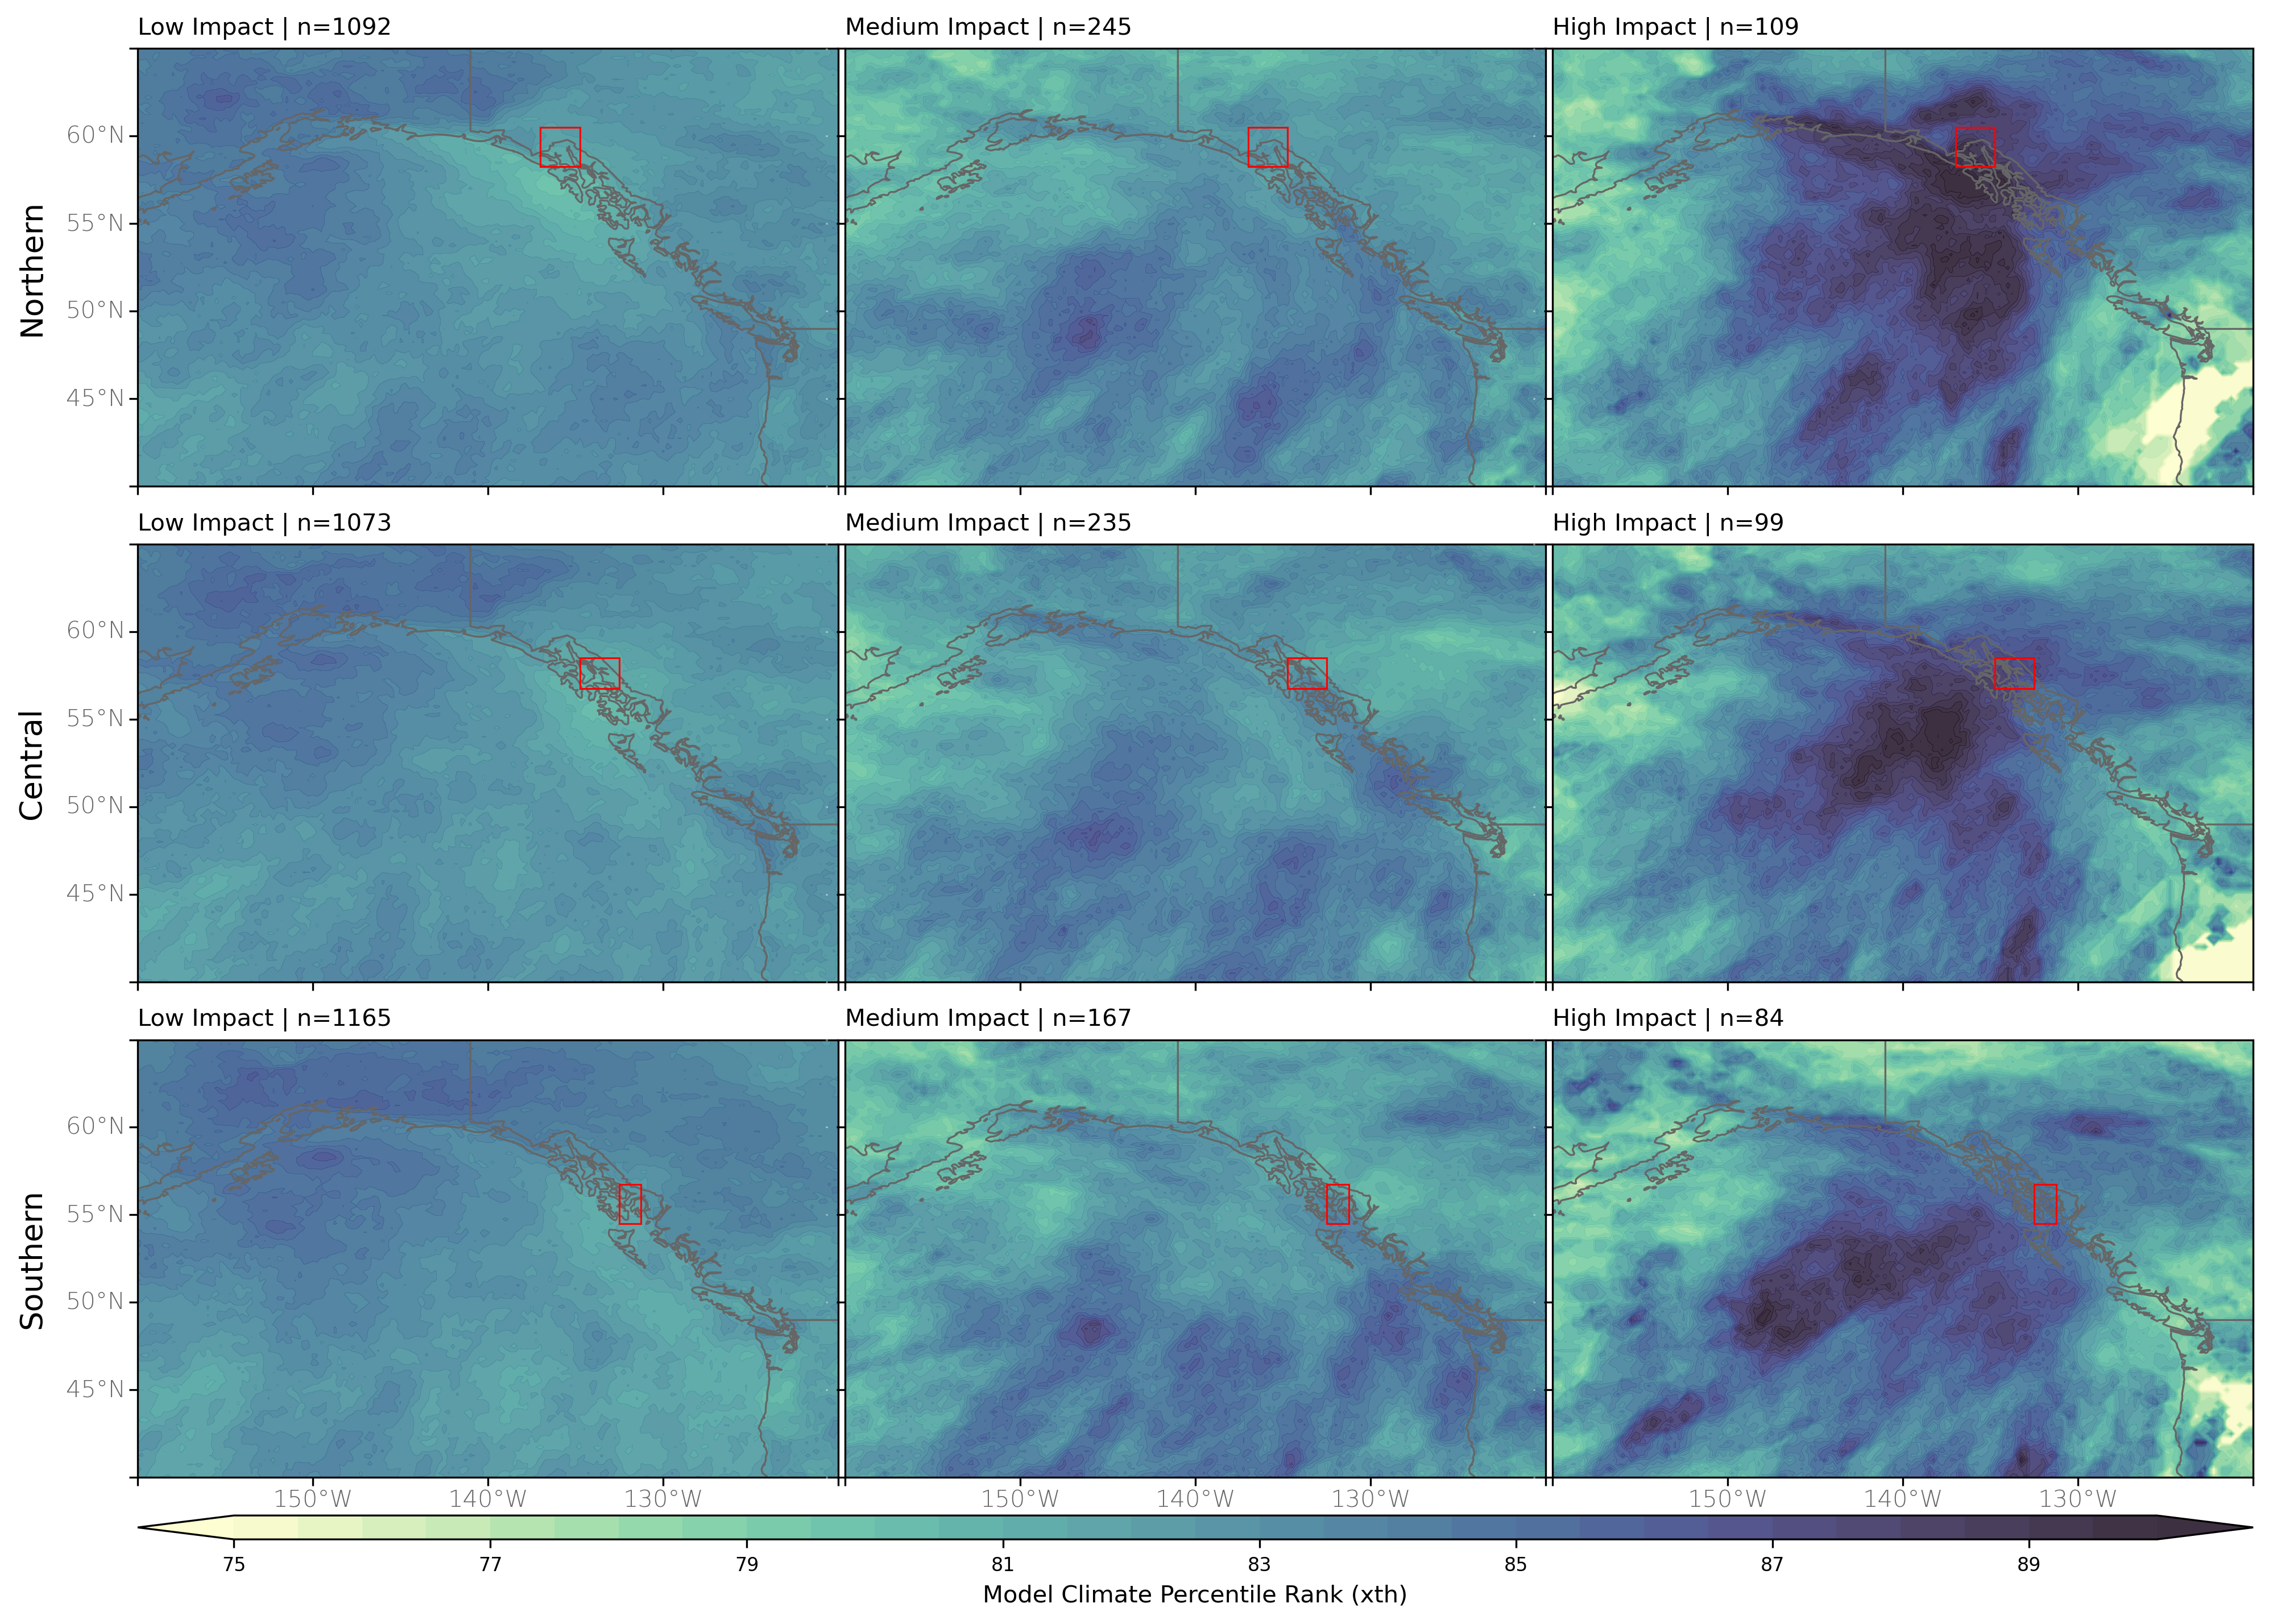

In [8]:
# Create figure
fig = plt.figure(figsize=(16, 11.5))
fig.dpi = 300
fname = path_to_figs + 'impact_composite_{0}_{1}perc'.format(region, perc_coverage)
fmt = 'png'

nrows = 4
ncols = 3

# contour labels
kw_clabels = {'fontsize': 7, 'inline': True, 'inline_spacing': 7, 'fmt': '%i',
              'rightside_up': True, 'use_clabeltext': True}

kw_ticklabels = {'size': 10, 'color': 'dimgray', 'weight': 'light'}

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 1, 1, 0.05], width_ratios = [1, 1, 1], wspace=0.01, hspace=0.05)
## use gs[rows index, columns index] to access grids

##################
### COMPOSITES ###
##################
leftlats_lst = [True]*3 + [False]*6
bottom_lons_lst = [False, False, True]*3
lbl = ['Low Impact']*3 + ['Medium Impact']*3 + ['High Impact']*3
region_lst = ['Northern', 'Central', 'Southern']
row_idx = [0, 1, 2]*3
col_idx = [0, 0, 0, 1, 1, 1, 2, 2, 2]
for i, fc in enumerate(data_lst):
    ax = fig.add_subplot(gs[row_idx[i], col_idx[i]], projection=mapcrs) 
    ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=leftlats_lst[i], right_lats=False, bottom_lons=bottom_lons_lst[i])
    
    # Contour Filled
    data = fc.ivt_mclimate.values*100.
    # cmap, norm, bnds = ccmap.cmap('mclimate_purple')
    # cf = ax.contourf(fc.lon, fc.lat, data, transform=datacrs,
    #                  levels=bnds, cmap=cmap, norm=norm, alpha=0.9, extend='neither')

    cmap = cmo.deep
    bnds = np.arange(75, 90.5, 0.5)
    cf = ax.contourf(fc.lon, fc.lat, data, transform=datacrs,
                     levels=bnds, cmap=cmap, alpha=0.9, extend='both')

    ax.set_title('{0} | n={1}'.format(lbl[i], ndays[i]), loc='left', fontsize=10)

    if col_idx[i] == 0:
        ax.text(-0.13, 0.5, region_lst[i], va='bottom', ha='center',
                rotation='vertical', rotation_mode='anchor', fontsize=13,
                transform=ax.transAxes)

    patch = bboxes[row_idx[i]]
    ax.add_patch(mpatches.Rectangle(xy=[patch[0], patch[2]], width=patch[1]-patch[0], height=patch[3]-patch[2],
                                fill=False,
                                edgecolor='r',
                                linewidth=0.75,
                                transform=datacrs,
                                zorder=199))


# Add color bar
cbax = plt.subplot(gs[-1,:]) # colorbar axis
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal', ticklocation = 'bottom')
cb.set_label('Model Climate Percentile Rank (xth)', fontsize=10)
cb.ax.tick_params(labelsize=8)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()